## Making QQ plots

Imports.

In [1]:
import matplotlib.pyplot as plt # make simple visualizations
import pandas as pd # data management
import numpy as np # data management

import io_helpers # file I/O

print(f'''
This notebook adds:
NumPy version {np.__version__}
''')


This I/O helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1,
pandas version 1.5.3


This notebook adds:
NumPy version 1.24.3



Constants.

In [2]:
gene_map = io_helpers.read_col('data', 'expression', 'gene_name_map.csv',
                               colname='ensembl_id', index_col='gene_name')
tissue_map = io_helpers.read_col('data', 'expression', 'tissue_name_map.csv', 
                                 colname='long_name', index_col='short_name')

cis_contigs = io_helpers.read_csv('data', 'expression', 'Y_MT_cis_contigs.tsv',
                                  sep='\t', index_col='chr')
# allows for vectorized indexing
COLORS = pd.Series(io_helpers.COLORBLIND_PALETTE)

# force size compatible to effect plot
plt.rcParams['figure.figsize'] = (5, 4.5)

Helper functions.

In [3]:
def pval_qqplot(tests: pd.DataFrame, chrom: str, description: str, 
                italic_label: bool, color_priority: list[str] = None) -> None:
    """Create a basic QQ plot.

    Parameters
    ----------
    tests: pd.DataFrame
        Results of association tests, with 'p', 'text', and 'color' columns.
        Note that 'color' is an index within `COLORBLIND_PALETTE`.
    chrom: str
        Name of chromosome for plot title.
    description: str
        Description of type of association test for plot title.
    italic_label: bool
        Whether to italicize the point labels from 'text'.
    color_priority: list[str], optional
        Labels for different colors, in order of plotting from bottom to top.
    """

    # sort tests by p value so as to add expected quantiles
    tests.dropna(subset='p', inplace=True)
    tests.sort_values('p', ascending=True, inplace=True)
    tests['null_p'] = (np.arange(1, tests.shape[0] + 1) - 0.5) / tests.shape[0]

    # -log10(p) is plotted instead of p, to make small values show up well
    tests['x'] = -np.log10(tests['null_p'])
    tests['y'] = -np.log10(tests['p'])

    def plot_tests(rows: pd.Series, marker: str = '.', label: str = None) -> None:
        """Add points to QQ plot."""
        plt.scatter(tests.loc[rows, 'x'], tests.loc[rows, 'y'], 
                    c=COLORS[tests.loc[rows, 'color']], 
                    marker=marker, label=label, rasterized=True)

    is_sig = tests['adj_p'] < 0.05
    plot_tests(rows=~is_sig)
    if any(is_sig): plot_tests(rows=is_sig, marker='^')
    # line of expectation
    plt.axline((0, 0), slope=1, color='black')

    if color_priority is not None:
        for i in range(0, len(color_priority)):
            # only replot non-sig dots, so as to avoid messing up triangles
            colored_nonsig = (tests['color'] == i) & ~is_sig
            plot_tests(rows=colored_nonsig, label=color_priority[i])
    
    text_style = 'italic' if italic_label else None
    for row in np.where(tests['text'] != '')[0]:
        cur_row = tests.iloc[row]
        plt.text(cur_row['x'] - 0.1, cur_row['y'], cur_row['text'],
                 horizontalalignment='right', style=text_style)
    
    plt.title(f'{chrom} haplotype to {description} associations')
    plt.xlabel('Expected -log10(pval)', fontsize=13)
    plt.ylabel('Actual -log10(pval)', fontsize=13)
            
def gcta_qqplot(chrom: str) -> None:
    """Create and save a QQ plot for GWAS phenotypes.

    Parameters
    ----------
    chrom: str
        Name of chromosome to plot tests for.
    """

    tests = io_helpers.read_csv('results', 'associations', 
                                f'{chrom}_GWAS_phenotype_tests.csv')
    tests['text'] = np.where(tests['adj_p'] < 0.05, tests['name'], '')
    tests['color'] = 3
    
    pval_qqplot(tests, chrom, 'GWAS phenotype', italic_label=False)
    io_helpers.save_plot(f'{chrom}_GWAS_phenotype_QQplot')

def eqtl_qqplot(chrom: str, gene_names: list[str]) -> None:
    """Create and save a QQ plot for gene expression.

    Parameters
    ----------
    chrom: str
        Name of chromosome to plot tests for.
    gene_names: list[str]
        Common names of genes to label (i.e. the top associations).
    """
    
    tests = io_helpers.read_csv('results', 'associations', 
                                f'{chrom}_gene_expression_tests.csv')

    # in general, genes are colored by whether they are cis or trans
    contigs = cis_contigs.loc[chrom, 'contigs'].split(',')
    tests['color'] = np.where(tests['chr'].isin(contigs), 1, 0)
    # a few special genes get their own colors
    for i in range(len(gene_names)):
        gene_rows = tests['ensembl_id'] == gene_map.loc[gene_names[i]]
        # first two colors reserved for cis/trans
        tests.loc[gene_rows, 'color'] = i + 2
        tests.loc[gene_rows, 'name'] = gene_names[i]

    tests['tissue'] = tissue_map.loc[tests['tissue']].to_list()
    tests['text'] = ''
    for row in range(len(gene_names)):
        cur_row = tests.iloc[row]
        label = (cur_row['name'] + ' ' + io_helpers.roman_format('in') + ' ' 
                 + io_helpers.roman_format(cur_row['tissue']))
        tests.loc[tests.index[row], 'text'] = label

    other_types = [io_helpers.roman_format('other (trans)'),
                   io_helpers.roman_format('other (cis)')]
    pval_qqplot(tests, chrom, 'gene expression', italic_label=True, 
                color_priority=other_types + gene_names)
    plt.legend(loc='center left', prop={'style': 'italic'})
    io_helpers.save_plot(f'{chrom}_gene_expression_QQplot')

Make QQ plots

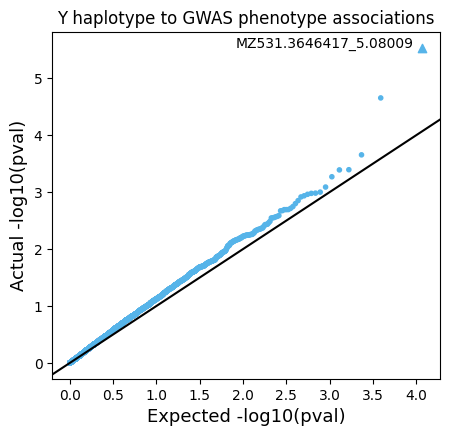

In [4]:
# Figure 3A
gcta_qqplot('Y')

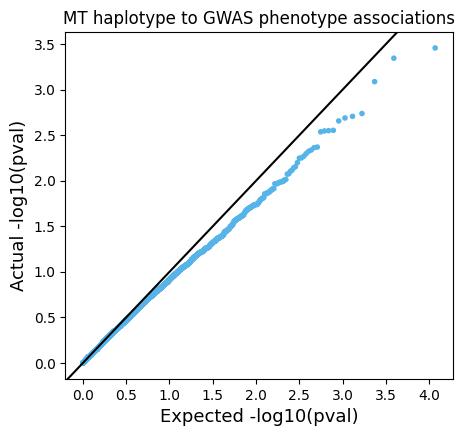

In [5]:
# Figure 4A
gcta_qqplot('MT')

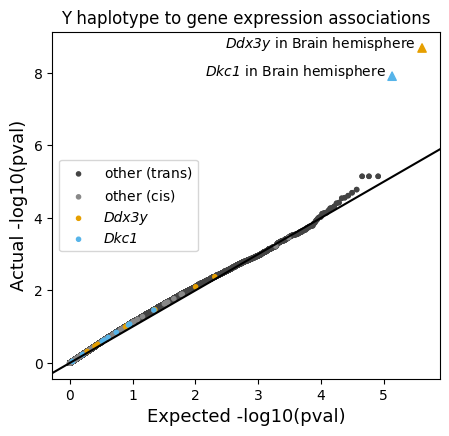

In [6]:
# Figure 3B
eqtl_qqplot('Y', ['Ddx3y', 'Dkc1'])

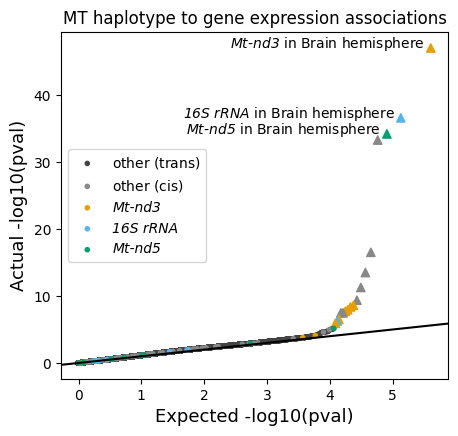

In [7]:
# Figure 4B
eqtl_qqplot('MT', ['Mt-nd3', '16S rRNA', 'Mt-nd5'])